In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.data.core import *
from fastai2.distributed import *
from fastai2.data.transforms import *
import gc
from itertools import product
from scipy import signal
import seaborn as sns
import mne

In [3]:
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 300
rcParams['agg.path.chunksize'] = 10000

In [4]:
SEGMENT_SIZE = 500000 
WINDOW_SIZE = 400
BS = torch.cuda.device_count() * 192
SPLITS = 5
AUGMENT_FLIP = False
XTRA_DS = False

FEAT_WINDOW = 1

assert SEGMENT_SIZE % WINDOW_SIZE == 0
assert (SEGMENT_SIZE // WINDOW_SIZE) % SPLITS == 0
SEED = 321
DATA_SUFFIX = '_clean'

p_input = Path('input')

# Read data

In [5]:
# read data
train_dtypes = {'time': np.float32, 'signal': np.float32, 'open_channels': np.int32 }
test_dtypes  = {'time': np.float32, 'signal': np.float32 }
df_train  = pd.read_csv(p_input / f'train.csv', dtype= train_dtypes)
df_test   = pd.read_csv(p_input / f'test.csv',  dtype= test_dtypes)
df_train_drift = pd.read_csv(p_input / f'train{DATA_SUFFIX}.csv', dtype= train_dtypes)
df_test_drift  = pd.read_csv(p_input / f'test{DATA_SUFFIX}.csv',  dtype= test_dtypes)
sub   = pd.read_csv(p_input / 'sample_submission.csv',  dtype={'time': np.float32})
df_train['drift'] = df_train['signal'] - df_train_drift['signal']
df_test['drift']  = df_test['signal']  - df_test_drift['signal']

In [6]:
df_train['signal'] =  df_train_drift['signal']
df_test['signal']  =   df_test_drift['signal']

In [7]:
#df_train['open_channels'][2300000:2400000][(df_train['open_channels'][2300000:2400000]==0)]=1

In [8]:
d_xtra_csvs = {
    1: ['outfinaltest10.csv',  'outfinaltest44.csv',],#  'outfinaltest78.csv',],  'outfinaltest10.csv',  'outfinaltest44.csv'],
    3: ['outfinaltest1.csv',   'outfinaltest2.csv',   'outfinaltest3.csv',   'outfinaltest4.csv', 'outfinaltest5.csv'],
    5: ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv',]#, 'outfinaltest328.csv', 'outfinaltest534.csv']
}

df_train_xtra = None
for _,xtra_csvs in d_xtra_csvs.items():
    for xtra_csv in xtra_csvs:
        xx = pd.read_csv(p_input / xtra_csv , header=None,names=['time', 'signal', 'open_channels'])
        df_train_xtra = pd.concat((xx,df_train_xtra), axis=0)
df_train_xtra['drift']  = 0.
if XTRA_DS: df_train = pd.concat((df_train,df_train_xtra), axis=0)

In [9]:
train = torch.cat((torch.FloatTensor(df_train['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['drift'         ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['open_channels' ].values).unsqueeze(0)))
test  = torch.cat((torch.FloatTensor(df_test ['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_test ['drift'         ].values).unsqueeze(0)))

# Synth

In [10]:
p_synth = Path('synth')

use_memmap = True
load_fn = np.load if not use_memmap else partial(np.lib.format.open_memmap, mode='r')
try:
    high = load_fn(str(p_synth / 'high.npy'))
    low  = load_fn(str(p_synth / 'low.npy'))
except:
    high = pd.read_csv(p_synth / 'high.csv',header=None).values.astype('uint8')
    low  = pd.read_csv(p_synth /  'low.csv',header=None).values.astype('uint8')
    np.save(str(p_synth / 'high.npy'), high)
    np.save(str(p_synth /  'low.npy'),  low)
high = high.reshape(-1,SEGMENT_SIZE)
low  =  low.reshape(-1,SEGMENT_SIZE)

In [11]:
def get_synth_segment_y(states,max_channels,size=SEGMENT_SIZE):
    y = np.zeros((size,),dtype=np.uint8)
    for i in np.random.choice(states.shape[0],max_channels,replace=False):
        o = np.random.randint(1+SEGMENT_SIZE-size)
        #print(i,o)
        y += states[i,o:o+size]
    return np.clip(y, 0, 10)
np.bincount(get_synth_segment_y(low,3,SEGMENT_SIZE//5),minlength=11)
# (low,1), (low,1), (high,1), (high,3), (high,10), (high,5), (high,1), (high,3), (high,5), (high,10)

array([90699,  9301,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [12]:
for i in range(10): print(np.bincount(get_synth_segment_y(low,5,SEGMENT_SIZE//5),minlength=11))


[80483 17087  2430     0     0     0     0     0     0     0     0]
[85025 14529   446     0     0     0     0     0     0     0     0]
[83483 16232   285     0     0     0     0     0     0     0     0]
[81087 17894  1019     0     0     0     0     0     0     0     0]
[89215 10646   139     0     0     0     0     0     0     0     0]
[91502  8171   327     0     0     0     0     0     0     0     0]
[87777 11876   347     0     0     0     0     0     0     0     0]
[83785 14378  1837     0     0     0     0     0     0     0     0]
[84472 14721   807     0     0     0     0     0     0     0     0]
[75081 23546  1306    67     0     0     0     0     0     0     0]


# Filter 

def filter(x):
    return mne.filter.notch_filter(x.numpy().astype('float64'),10000,50.0)
train[0,:]=Tensor(filter(train[0,:]))
test[0,:] =Tensor(filter( test[0,:]))

In [13]:
train = train.view(train.shape[0],-1,SEGMENT_SIZE)
test  =  test.view( test.shape[0],-1,SEGMENT_SIZE)

In [14]:
#train = train[:,[4,9],:]
train = train[:,[0,1,2,3,4,5,6,8,9],:]

# EDA

In [15]:
means = FloatTensor([-2.73135856, -1.49979538, -0.26823219, 0.963331,   2.19489419, 3.42645737,
                    np.nan,        np.nan,    np.nan,     np.nan,     np.nan])

In [16]:
from scipy.ndimage.interpolation import shift


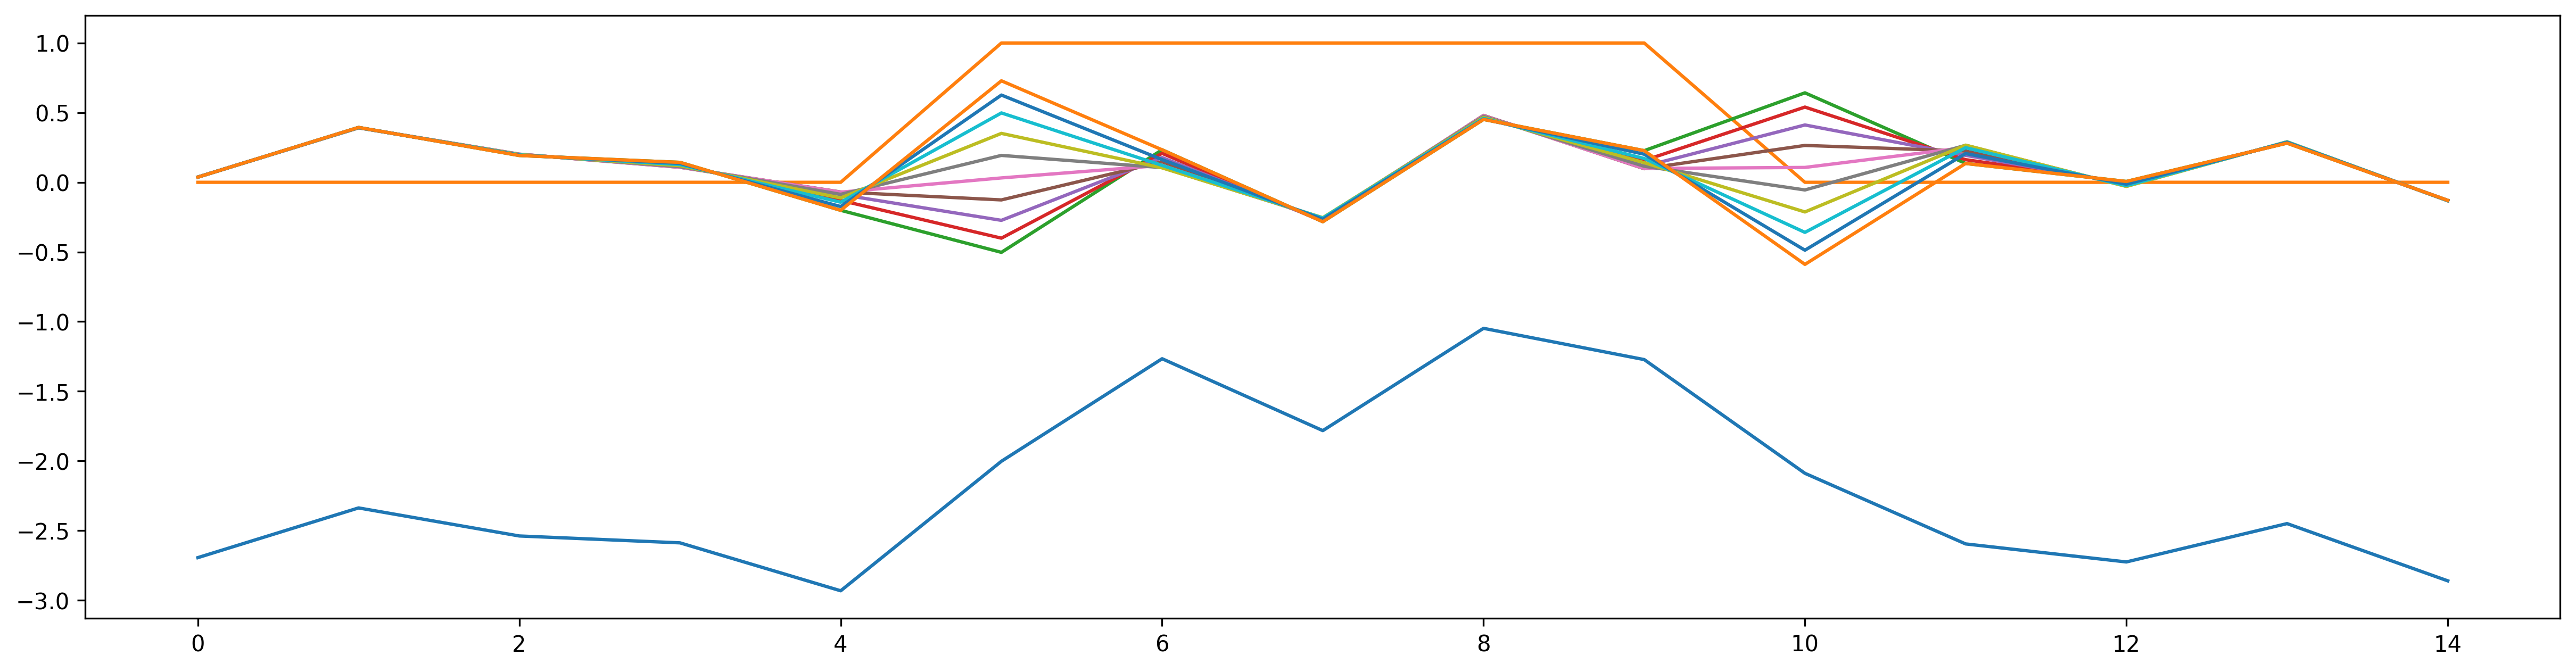

In [17]:
sf = 1
x = F.interpolate(train[0,0,:].view(1,1,-1),scale_factor=sf).squeeze()
y = F.interpolate(train[2,0,:].view(1,1,-1),scale_factor=sf).squeeze()
x,y = train[0,0,:],train[2,0,:]
#x = x[1:] - x[:-1]
w = means[1]-means[0]
b = means[0]
n = x-(w*y+b)

s0,s1=7225,7240
ss=slice(s0*sf,s1*sf)
plt.plot(x[ss])
plt.plot(y[ss])
x.shape
from scipy.ndimage.interpolation import shift

for s in np.linspace(0,1,10):
    noise = x - (w*shift(y,s,order=3) + b)
    plt.plot(noise[ss])

def _noise(params):
    b,s,w,w1,w2,b1,b2 = params
    return x - w*(shift(y,s,order=1)+b) - w1*(shift(y,s+1,order=1)+b1) - w2*(shift(y,s+2,order=1)+b2)

def noise_std(params): return np.std(_noise(params))
for ss in [[4,9],[4],[9],[0],[1],[0,1],[2],[6],[2,6]]:
    x,y = train[0,ss,:].flatten().numpy(),train[2,ss,:].flatten().numpy()
    res = scipy.optimize.minimize(noise_std,([0.]*7),method='COBYLA', options={'disp':True},)
    print(ss,res.x,noise_std(res.x))

In [18]:
train.shape

torch.Size([3, 9, 500000])

In [19]:
def get_hist(y):
    SS = y.shape[1]
    l_train = y.shape[0]*SS
    train_channels_in_segment=torch.zeros((y.shape[0],11))
    for i,s in enumerate(range(0,l_train,SS)):
        train_channels_in_segment[i] = torch.histc(y[i,:],11,0,11)
    return train_channels_in_segment.long()

train_channels_in_segment = get_hist(train[2])
train_channels_in_segment//5

tensor([[96826,  3173,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [96132,  3867,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [25200, 74799,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [ 2355, 17386, 43376, 36881,     0,     0,     0,     0,     0,     0,
             0],
        [    0,    11,   105,   685,  2925,  9029, 18555, 26463, 24648, 13930,
          3645],
        [  191,  2346, 11846, 29466, 37516, 18632,     0,     0,     0,     0,
             0],
        [24639, 75361,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  193,  2375, 12012, 29646, 37169, 18602,     0,     0,     0,     0,
             0],
        [    0,    13,   112,   702,  3071,  9311, 19066, 26539, 24388, 13294,
          3501]])

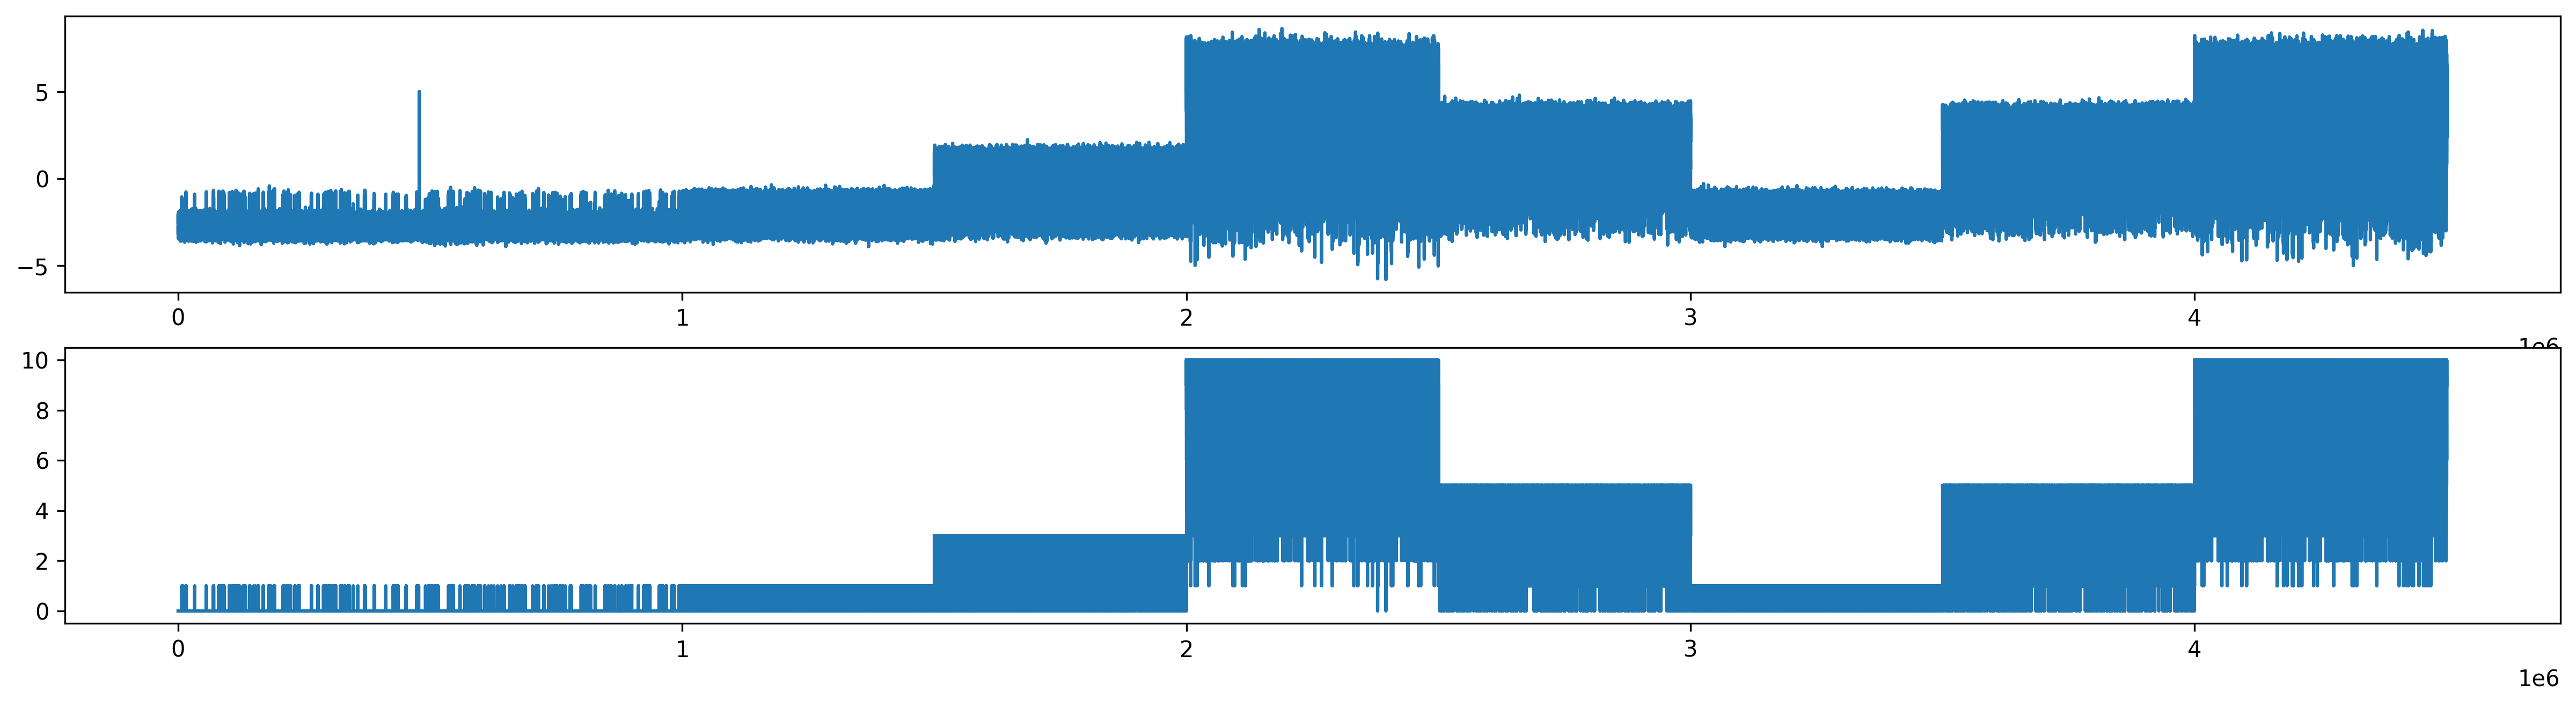

In [20]:
si = train[0,:,:].flatten()#  + train[1,:,:].flatten()
oc = train[2,:,:].flatten()
plt.subplot(2, 1, 1)
plt.plot(si)
plt.subplot(2, 1, 2)
plt.plot(oc)

In [21]:
means = FloatTensor([[-2.73135856, -1.49979538, -0.26823219, 0.963331,   2.19489419, 3.42645737,
                    np.nan,        np.nan,    np.nan,     np.nan,     np.nan],
                    [-5.49309926, -4.25506493, -3.0170306, -1.77899627,  -0.54096195, 0.69707238,
                     1.93510671,  3.17314104, 4.41117536, 5.64920969, 6.88724402]])

noises = []
si = train[0,[4,8],:].flatten()
oc = train[2,[4,8],:].flatten().long()

for i in range(11):
    noise = si[oc==i]-means[1][i]
    plt.plot(noise)
    noises.append(noise)
    print(noise.std())

#si = train[:,[0,1,2,3,4,5,6,8,9],:]

si = train[0,[0,1,2,3,5,6,7],:].flatten()
oc = train[2,[0,1,2,3,5,6,7],:].flatten().long()
noises = []

for i in range(11):
    noise = si[oc==i]-means[0][i]
    plt.plot(noise)
    noises.append(noise)
    print(noise.std())

#si = train[:,[0,1,2,3,4,5,6,8,9],:]
noises[0]

plt.figure(figsize=(10,40))
plt.subplot(13,1,1)
plt.plot(oc)
plt.subplot(13,1,2)
plt.plot(si)
SS = 500000

for i in range(11):
    plt.subplot(13,1,i+3)
    ss = si.clone()
    ss[oc != i] = Tensor([np.nan])
    ss[0] =  si.min()
    ss[-1] = 9
    
    for s in range(10):
        sss = slice(s*SS,(s+1)*SS)
        v = si[sss][oc[sss] == i]
        
        mean,std = v.mean(), v.std()
        
        if ~torch.isnan(mean):
            plt.annotate(f'{mean.item():0.02f}',xy=(SS/2+s*SS, 7), xycoords='data',
                        horizontalalignment='center', verticalalignment='bottom')

        if ~torch.isnan(std):
            plt.annotate(f'{std.item():0.02f}',xy=(SS/2+s*SS, -5), xycoords='data',
                        horizontalalignment='center', verticalalignment='bottom')
        if s==5: print(f"{std.item():0.02f},",end="")
            
    plt.plot(ss)

In [22]:
#sns.distplot(si[:SS])

# Normalize

In [23]:
def build_lag_lead(x,DIM):
    if DIM < 2: return x.unsqueeze(-1)
    w = DIM//2
    assert w > 1
    ws = x.shape[-1]
    r = math.ceil(w/ws) + 1
    x_lead  = x.repeat(1,1,r)[...,:ws+w-1]
    x_lag   = x.repeat(1,1,r).flip((2))[...,:ws+w-1]
    lead,lag=x_lead.unfold(2,w,1), x_lag.unfold(2,w,1).flip((2))
    lag[...,0] = lag[...,0]**2
    return torch.cat((lead,lag),dim=3)
train = build_lag_lead(train,FEAT_WINDOW)
test  = build_lag_lead(test, FEAT_WINDOW)
train.shape,test.shape

(torch.Size([3, 9, 500000, 1]), torch.Size([2, 4, 500000, 1]))

In [24]:
signal_mean, signal_std = train.mean(dim=(0,1,2)),train.std(dim=(0,1,2))
train[0] = ((train[0] - signal_mean) / signal_std)
test[0]  = (( test[0] - signal_mean) / signal_std)

In [25]:
test_channels_in_segment = FloatTensor([
    [1,1,0,0,0,0,0,0,0,0,0], # A
    [1,1,1,1,0,0,0,0,0,0,0], # B
    [0,1,1,1,1,1,0,0,0,0,0], # C
    [1,1,0,0,0,0,0,0,0,0,0], # D
    [1,1,0,0,0,0,0,0,0,0,0], # E
    [0,0,0,0,1,1,1,1,1,1,1], # F
    [1,1,1,1,1,1,0,0,0,0,0], # G
    [0,0,0,0,1,1,1,1,1,1,1], # H
    [1,1,0,0,0,0,0,0,0,0,0], # I
    [1,1,1,1,0,0,0,0,0,0,0], # J
    [1,1,0,0,0,0,0,0,0,0,0], # 
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
])
test_channels_in_segment = test_channels_in_segment.unsqueeze(0).repeat(100000//SEGMENT_SIZE,1,1).transpose(0,1).reshape(-1,11)
#assert test_channels_in_segment.shape[0]*SEGMENT_SIZE == test.shape[1]*test.shape[2]
test_channels_in_segment.shape

torch.Size([0, 11])

# Dataset and splits

In [26]:
split = 0
split_size = SEGMENT_SIZE//WINDOW_SIZE//SPLITS
splits_per_segment = np.arange(SEGMENT_SIZE//WINDOW_SIZE)
valid_split_idx = split*split_size + np.arange(split_size)
all_segments = range(train.shape[1])
valid_idx = list(product(range(50) if XTRA_DS else all_segments,valid_split_idx))
train_idx = list(product(all_segments,splits_per_segment))
train_idx = list(sorted(set(train_idx).difference(set(valid_idx))))

In [27]:
# SYNTH
#train_idx = list(product(range(len(all_segments)*10),splits_per_segment))
#valid_idx = list(product([0, 1, 2, 3, 4, 5, 6, 8, 9],splits_per_segment))

In [28]:
class IonDataset(torch.utils.data.Dataset):
    def __init__(self, data,idx=None,jitter=False,p_flip=0.,balance=False,synth=False):
        super().__init__()
        self.data, self.channels_in_segment,self.jitter,self.p_flip,self.synth = *data, jitter, p_flip,synth
        self.idx = ifnone(idx,list(product(range(self.data.shape[1]),np.arange(SEGMENT_SIZE//WINDOW_SIZE))))
        self.n_inp = 1
        self.has_y = self.data.shape[0] == 3
        self.hist = torch.zeros((11,))
    def __len__(self): return len(self.idx)
    def __getitem__(self, idx):
        s,o=self.idx[idx]
        jitter = 0
        if self.synth and self.has_y:
            segment_types=[( low, 1),( low, 1),(high, 1),(high, 3),(high,10),(high, 5),(high, 1),(high, 3),(high, 5),(high,10),
                           (high,10),(high,10),(high,10),(high,11),(high,11),(high,12),(high,13),(high,13),(high,14),(high,14),]
            segment_type = segment_types[np.random.randint(len(segment_types))]
            y_open_channels = LongTensor(get_synth_segment_y(*segment_type,WINDOW_SIZE))
            
            if segment_type[1] >= 10:
                means = FloatTensor([-5.49309926, -4.25506493, -3.0170306, -1.77899627,  -0.54096195, 0.69707238,
                                     1.93510671,  3.17314104, 4.41117536, 5.64920969, 6.88724402])
                stds  = FloatTensor([0.42,0.42,0.42,0.42,0.41,0.41,0.41,0.41,0.41,0.41,0.42])
            else:
                means = FloatTensor([-2.73135856, -1.49979538, -0.26823219, 0.963331,   2.19489419, 3.42645737,
                                    np.nan,        np.nan,    np.nan,     np.nan,     np.nan])
                stds  = FloatTensor([0.30,0.29,0.29,0.29,0.29,0.29,np.nan,np.nan,np.nan,np.nan,np.nan])
            x = means[y_open_channels] + stds[y_open_channels] * torch.normal(0,1.,(y_open_channels.numel(),))
            x = build_lag_lead(x,FEAT_WINDOW).squeeze(0).squeeze(0)
            x = (x - signal_mean) / signal_std
            segment = x # hack
        else:
            if self.jitter:
                os,oe = 0,0
                if (s,(o-1)) in self.idx: os = -WINDOW_SIZE//2
                if (s,(o+1)) in self.idx: oe =  WINDOW_SIZE//2
                jitter = torch.randint(os,oe,(1,)).item()
            ss = slice(jitter+o*WINDOW_SIZE,jitter+(o+1)*WINDOW_SIZE)
            x =  self.data[0,s,ss,:]
            segment = self.data[0,s,:1,0]
            flip = (torch.rand(1) < self.p_flip).item()
            if flip: x,segment = torch.flip(x,dims=(1,)), torch.flip(segment,dims=(0,))
            if self.has_y: 
                y_drift,y_open_channels = (self.data[1,s:s+1,ss,0], self.data[2,s:s+1,ss,0].long())
                if flip: y_drift,y_open_channels=(torch.flip(y_drift,dims=(1,)),torch.flip(y_open_channels,dims=(1,)))

        x = (x,segment) 
        return (x,y_open_channels) if self.has_y else (x,)

    
train_ds = IonDataset((train, train_channels_in_segment), train_idx, jitter=True, synth=False)
valid_ds = IonDataset((train, train_channels_in_segment), valid_idx)
test_ds  = IonDataset((test,  test_channels_in_segment))
train_ds[0][0][0].shape

torch.Size([400, 1])

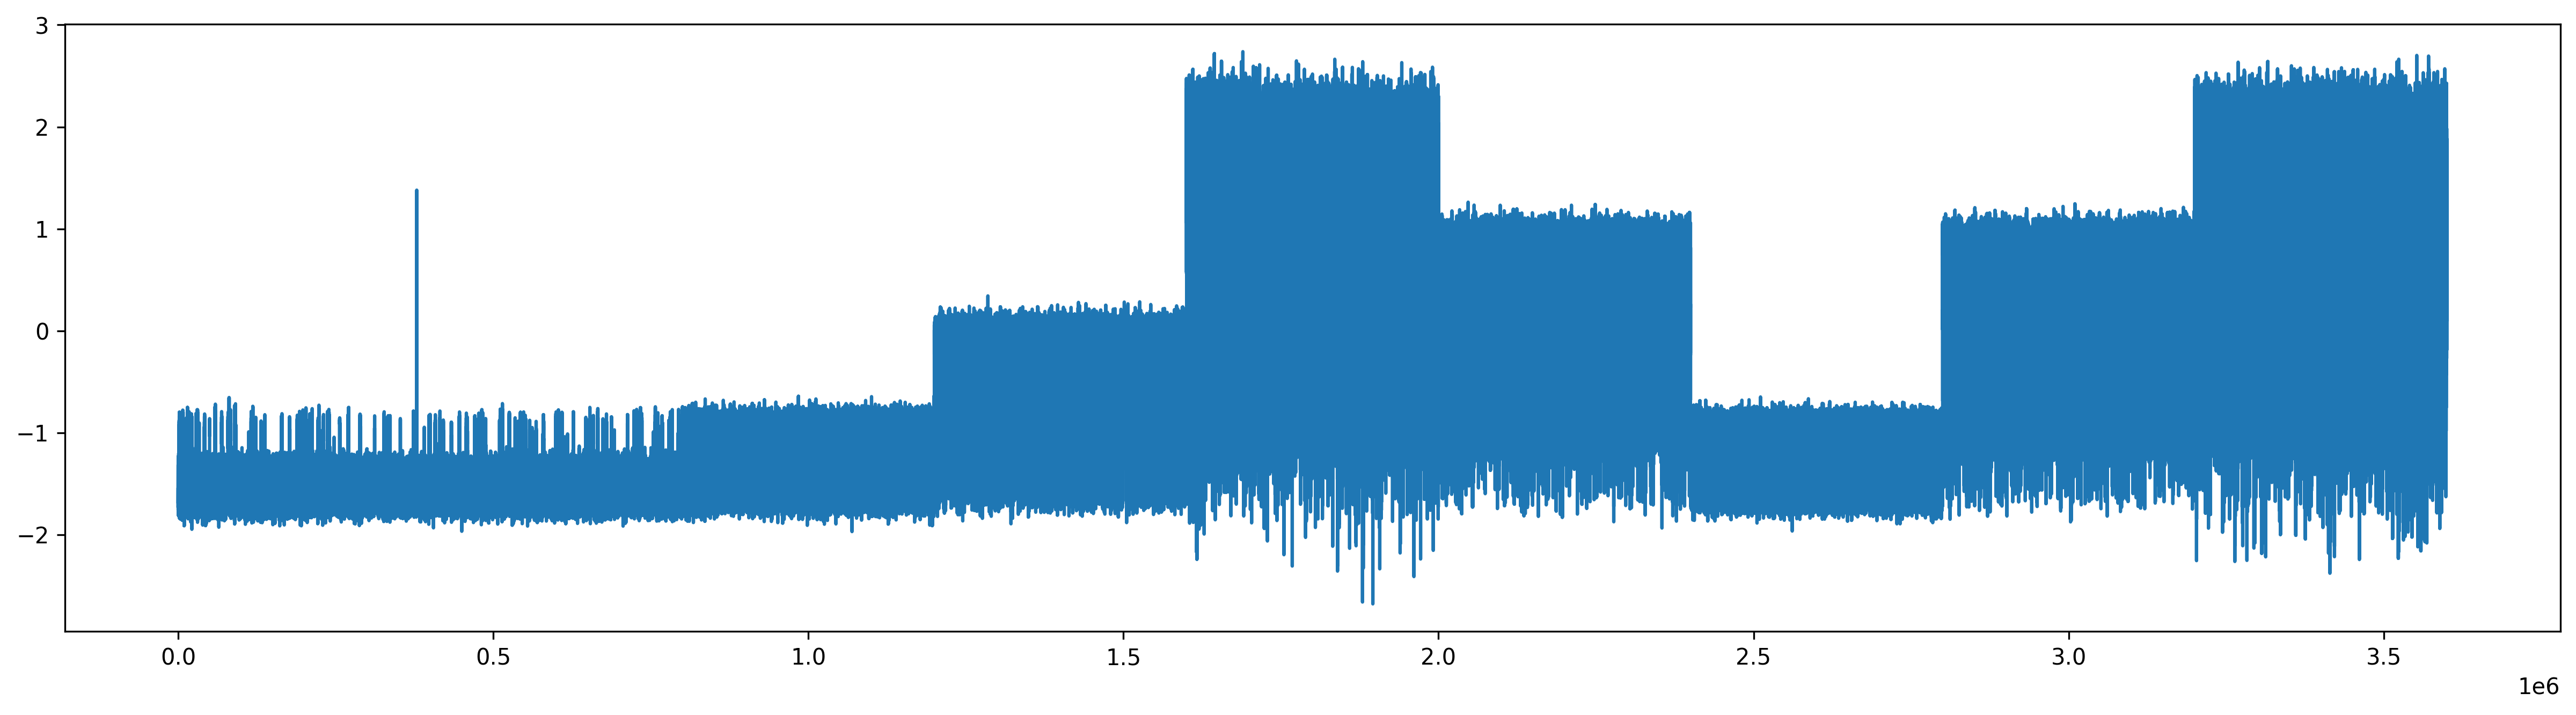

In [29]:
#train_ds = IonDataset((train, train_channels_in_segment), train_idx, jitter=False, synth=True)
len(train_ds)
x = torch.empty((len(train_ds),train_ds[0][0][0].shape[0]))
for i in range(len(train_ds)): x[i] = train_ds[i][0][0][:,0]
plt.plot(x.flatten())

In [30]:
train_dl = DataLoader(train_ds, BS,    shuffle=True,  num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, BS,    shuffle=False, num_workers=8, pin_memory=True)
test_dl  = DataLoader(test_ds,  BS//2, shuffle=False, num_workers=8, pin_memory=True)
test_ds[2],test_ds[2][0][1].shape

(((tensor([[-1.7041],
           [-1.4870],
           [-1.6487],
           [-1.2893],
           [-1.3751],
           [-1.3995],
           [-1.5909],
           [-1.4314],
           [-1.4192],
           [-1.5294],
           [-1.4766],
           [-1.5530],
           [-1.4398],
           [-1.5892],
           [-1.5766],
           [-1.4554],
           [-1.4984],
           [-1.4888],
           [-1.2567],
           [-1.3935],
           [-1.5485],
           [-1.5097],
           [-1.4650],
           [-1.6206],
           [-1.3894],
           [-1.5756],
           [-1.5679],
           [-1.4416],
           [-1.5540],
           [-1.5289],
           [-1.5061],
           [-1.5504],
           [-1.6243],
           [-1.5712],
           [-1.4234],
           [-1.4961],
           [-1.4024],
           [-1.5628],
           [-1.4389],
           [-1.5326],
           [-1.5517],
           [-1.5046],
           [-1.4340],
           [-1.4957],
           [-1.4224],
          

# Model 

In [31]:
# detail 
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        f_out = 256
        self.LSTM0 = nn.LSTM(input_size=FEAT_WINDOW, hidden_size=256, num_layers=1, batch_first=True, 
                            bidirectional=True, dropout=0.)
        self.LSTM  = nn.LSTM(input_size=256*2, hidden_size=256, num_layers=4, batch_first=True, 
                            bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(f_out*2, 11)

    def forward(self, x):
        x,_ = x
        x, _ = self.LSTM0(x)
        x, _ = self.LSTM(x)
        return self.fc(x),x

In [32]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device())

model = ReformerLM(
    num_tokens = 11,
    dim = dim,
    depth = depth,
    max_seq_len = WINDOW_SIZE,
    heads = heads,
    lsh_dropout = lsh_dropout,
    bucket_size=bucket_size,
    causal = False,
    use_full_attn = False,
    fixed_position_emb = False,
    n_hashes = 4,
)
model.token_emb = nn.Linear(1,dim)

In [33]:
model = Classifier()
model

Classifier(
  (LSTM0): LSTM(1, 256, batch_first=True, bidirectional=True)
  (LSTM): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=11, bias=True)
)

# Loss 

In [34]:
def softf1_loss(logits,true,weights=None):
    eps=0
    # 96 4000 11, 96 4000 1 
    n_classes = logits.shape[-1]
    weights = ifnone(weights,torch.ones((n_classes,),dtype=logits.dtype,device=logits.device))
    y_pred = logits.view(-1,n_classes).softmax(dim=-1)             
    y_true = F.one_hot(true.flatten(), n_classes).to(torch.float32)

    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    precision = tp / (tp + fp + eps )
    recall = tp / (tp + fn + eps )

    f1 = 2* (precision*recall) / (precision + recall + eps)
    f1 = f1.clamp(0,1) * weights
    f1 = f1[~torch.isnan(f1)].mean()
    return 1-f1

class SoftF1Loss(Module):
    def __init__(self, weight=None): self.weight = weight
    def forward(self, output, target): return softf1_loss(output, target, self.weight)

class LabelSmoothingCE(Module):
    def __init__(self, eps:float=0.65, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

class DriftChannelsLoss(Module):
    def __init__(self, losses, weights=None):
        self.losses, self.weights = losses, ifnone(weights, [1.] * len(losses))
        self.hist = torch.ones((11,))
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        i_open_channels,_ = input
        t_open_channels   = target
        self.hist = self.hist.to(device=t_open_channels.device) + t_open_channels.flatten().float().histc(11,0,11)
        weight = self.hist.sum() / self.hist
        return L([l()(i_open_channels,t_open_channels)*w for l,w in zip(self.losses, self.weights)]).sum()

# Metrics

In [35]:
import sklearn.metrics as skm

# Cell
class OpenChannelsAccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, sigmoid=False, thresh=None, to_np=False, invert_arg=False,
                 flatten=True, metric_name=None, **kwargs):
        store_attr(self,'func,dim_argmax,sigmoid,thresh,flatten,metric_name')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        t,p = learn.y,learn.pred[0] #learn.y[1],learn.pred[1]
        pred = p.argmax(dim=self.dim_argmax) if self.dim_argmax else p
        if self.sigmoid: pred = torch.sigmoid(pred)
        if self.thresh:  pred = (pred >= self.thresh)
        #pred = p.round()
        targ = t
        pred,targ = to_detach(pred),to_detach(targ)
        if self.flatten: pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):
        return ifnone(self.metric_name,self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__)

# Cell
def skm_to__open_channels_fastai(func, is_class=True, thresh=None, axis=-1, sigmoid=None, **kwargs):
    "Convert `func` from sklearn.metrics to a fastai metric"
    dim_argmax = axis if is_class and thresh is None else None
    sigmoid = sigmoid if sigmoid is not None else (is_class and thresh is not None)
    return OpenChannelsAccumMetric(func, dim_argmax=dim_argmax, sigmoid=sigmoid, thresh=thresh,
                       to_np=True, invert_arg=True, **kwargs)

def MF1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None, **kwargs):
    "F1 score for single-label classification problems"
    return skm_to__open_channels_fastai(skm.f1_score, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight, **kwargs)

def A(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = inp[0],targ#inp[1], targ[1]
    pred,targ = flatten_check(pred.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [36]:
mets = [MF1Score(labels=[l],average='macro', metric_name=f"f1_{l}") for l in range(11)]
mets.extend([MF1Score(labels=list(range(11)),average='macro', metric_name=f"f1"), A])

# Train

In [37]:
learn = None
gc.collect()
torch.cuda.empty_cache()
learn = Learner(dls,model,loss_func=DriftChannelsLoss([LabelSmoothingCE]),
                opt_func=RMSProp,metrics=mets, moms=None,)

#learn.callbacks.extend([F1Metric(learn)])

learn.to_parallel()#.to_fp16()
summary = learn.summary()
match = re.search(r'Total trainable params: ([0-9,]+)', summary)
model_params = int(match.group(1).replace(",",""))
print(summary)

Classifier (Input shape: ["['576 x 400 x 1', '576 x 1']"])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['576 x 400 x 512',  530,432    True      
________________________________________________________________
LSTM                 ['576 x 400 x 512',  6,307,840  True      
________________________________________________________________
Linear               576 x 400 x 11       5,643      True      
________________________________________________________________

Total params: 6,843,915
Total trainable params: 6,843,915
Total non-trainable params: 0

Optimizer used: <function RMSProp at 0x7f09231413a0>
Loss function: DriftChannelsLoss()

Callbacks:
  - TrainEvalCallback
  - ParallelTrainer
  - Recorder
  - ProgressCallback


In [38]:
modelname = 'wavenet7487787_t1000_v250_BS96_SS100000_WS4000_cv0.9398_clean'
try:
    learn.load(modelname, strict=False)
    print(f"Loaded {modelname}")
except:
    print(f"Failed to load {modelname}")

Failed to load wavenet7487787_t1000_v250_BS96_SS100000_WS4000_cv0.9398_clean


In [ ]:
lr_min, lr_steep=learn.lr_find()

In [ ]:
#learn.fit_flat_cos(100,lr=1e-3)

In [39]:
learn.fit_flat_cos(200,1e-3,pct_start=0.5)

epoch,train_loss,valid_loss,f1_0,f1_1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,f1,A,time
0,2.660082,2.297210,0.715112,0.036702,0.000000,0.000000,0.344022,0.021292,0.000000,0.000000,0.000000,0.000000,0.000000,0.101557,0.342211,00:18
1,2.449445,2.279706,0.739759,0.099221,0.000000,0.454582,0.269334,0.000916,0.000000,0.000111,0.054572,0.318858,0.000000,0.176123,0.386243,00:13
2,2.373200,2.303669,0.000025,0.565539,0.000748,0.564028,0.474057,0.000071,0.000000,0.352218,0.052715,0.000000,0.000000,0.182673,0.380180,00:13
3,2.331173,2.231340,0.949817,0.840317,0.312157,0.652697,0.353235,0.000000,0.000000,0.000000,0.000293,0.000000,0.000000,0.282592,0.616027,00:13
4,2.299030,2.232681,0.755174,0.180996,0.583209,0.512290,0.111563,0.000000,0.001721,0.052081,0.500228,0.000000,0.000000,0.245206,0.469980,00:13
5,2.273952,2.187192,0.956367,0.879706,0.646400,0.682418,0.553262,0.012337,0.057447,0.284473,0.525184,0.171618,0.000000,0.433565,0.700932,00:14
6,2.252866,2.188622,0.966219,0.901952,0.682433,0.613218,0.319011,0.000000,0.008858,0.044002,0.365591,0.024900,0.000000,0.356926,0.653394,00:13
7,2.256958,2.298631,0.791079,0.470244,0.487513,0.036843,0.000024,0.000246,0.029812,0.071691,0.145128,0.425421,0.000000,0.223455,0.422384,00:14
8,2.254469,2.232479,0.728262,0.038518,0.633251,0.700192,0.578527,0.000000,0.147920,0.355620,0.525448,0.132193,0.000000,0.349085,0.539904,00:14
9,2.244057,2.177421,0.951840,0.890285,0.710803,0.716035,0.619514,0.138869,0.273117,0.358956,0.508983,0.512646,0.000000,0.516459,0.722513,00:13


In [ ]:
learn.fit(10,1e-4)#,pct_start=0.5)

In [ ]:
#learn.opt_func=SGD
learn.loss_func=DriftChannelsLoss([CrossEntropyLossFlat, SoftF1Loss], [1.,10.])
learn.fit_flat_cos(10,5e-5)#,pct_start=0.5)

In [ ]:
learn.recorder.plot_loss()

In [40]:
cv,_,time = learn.recorder.log[-3:];cv,_,time

(0.9403163916265757, 0.9690699577331543, '00:14')

In [41]:
suffix = '' # '_synth'

In [43]:
modelname = f'lstm{model_params}_t{len(train_ds)}_v{len(valid_ds)}_BS{BS}_SS{SEGMENT_SIZE}_WS{WINDOW_SIZE}_FW{FEAT_WINDOW}_cv{cv:0.04f}{DATA_SUFFIX}{suffix}'
learn.save(modelname);modelname

'lstm6843915_t9000_v2250_BS576_SS500000_WS400_FW1_cv0.9403_clean'

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_preds, valid_preds = learn.get_preds(0), learn.get_preds(1)
train_preds = train_preds[0][1],train_preds[1]
valid_preds = valid_preds[0][1],valid_preds[1]

In [ ]:
d_feats = train_preds[0].shape[-1]

In [ ]:
x0 = np.hstack((learn.model.fc._parameters['weight'].t().cpu().detach().numpy().flatten(),
                learn.model.fc._parameters['bias'].cpu().detach().numpy().flatten()))
x0.shape

In [ ]:
x0.shape

In [ ]:
#x,y = train_preds[0].view(-1,d_feats).cuda(),train_preds[1].view(-1).cuda()
x = y = None
gc.collect()
torch.cuda.empty_cache()
#x,y = valid_preds[0].view(-1,d_feats).cuda(),valid_preds[1].view(-1).cuda()
x,y = train_preds[0].view(-1,d_feats).cuda(),train_preds[1].view(-1).cuda()


In [ ]:
true   = y
evals = 0
max_evals = len(x0) 
print(max_evals)
imb = master_bar(range(max_evals), total=max_evals)
def adjust_thresholds(thresholds):
    global evals,imb
    m = Tensor(thresholds[:11*d_feats]).view(d_feats,11).cuda()
    b = Tensor(thresholds[11*d_feats:]).view(1,11).cuda()
    preds = (x @ m + b).argmax(dim=-1)
    
    y_pred = F.one_hot(preds,11)                    # S, C
    y_true = F.one_hot(true, 11).to(torch.float32)  # S, C
    
    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    precision = tp / (tp + fp )
    recall = tp / (tp + fn )

    f1 = 2* (precision*recall) / (precision + recall)
    f1 = f1.mean().cpu().numpy()

    if evals % 1000 == 0: print(f'{100*evals/max_evals:0.02f}% {f1:0.06f}')#, thresholds)
    evals += 1
    return 1-f1
    
def callback(xk):
    print(evals)
    return False if evals > max_evals else True

res = scipy.optimize.minimize(adjust_thresholds, x0,method='Powell', 
                              options={'disp':True, 'maxfev' : max_evals },
                              callback= callback)

In [ ]:
res.x

In [ ]:
x0 = res.x

In [ ]:
learn.model.fc._parameters['weight']

In [ ]:
learn.model.fc._parameters['weight'].data = Tensor(res.x[:11*d_feats]).view(d_feats,11).t().cuda()
learn.model.fc._parameters['bias'].data   = Tensor(res.x[11*d_feats:]).cuda()

In [ ]:
learn.model.fc._parameters['weight'],learn.model.fc._parameters['bias']

In [ ]:
class F1Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.d = data[0].shape[-1]
        self.x,self.y = data[0].view(-1,self.d),data[1].view(-1)
        self.n_inp = 1
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx].unsqueeze(1),self.y[idx]#.unsqueeze(-1)
    
f1_train_ds,f1_valid_ds = F1Dataset(train_preds), F1Dataset(valid_preds)
f1_train_dl = DataLoader(f1_train_ds, len(f1_train_ds)//100, shuffle=True,   num_workers=8, pin_memory=True)
f1_valid_dl = DataLoader(f1_valid_ds, len(f1_train_ds)//100, shuffle=False,  num_workers=8, pin_memory=True)

In [ ]:
d_feats = train_preds[0].shape[-1]

In [ ]:
f1model = nn.Sequential(nn.Conv1d(d_feats   , d_feats//2,3,1,1,groups=1), nn.ReLU(), 
                        nn.Conv1d(d_feats//2, d_feats//4,3,1,1,groups=1), nn.ReLU(), 
                        nn.Conv1d(d_feats//4 ,        11,3,1,1,groups=1),
                        Flatten())

In [ ]:
f1learn = None
gc.collect()
torch.cuda.empty_cache()
f1learn = Learner(DataLoaders(f1_train_dl,f1_valid_dl, device=default_device()),f1model,
                  loss_func=CrossEntropyLossFlat(),opt_func=Adam,
                  metrics=[F1Score(labels=list(range(11)),average='macro'), accuracy])
f1learn.summary()

In [ ]:
f1learn.fit(1,1e-3)

In [ ]:
f1learn.loss_func = softf1_loss

In [ ]:
f1learn.fit_one_cycle(20,5e-3)

In [ ]:
learn.model=learn.model.module

In [ ]:
learn.model

# Test

In [ ]:
learn.model.eval()
test_preds = torch.zeros(len(test_ds)*test_ds[0][0][0].shape[0],11,dtype=torch.float)
n_tta = 0
learn.model = nn.DataParallel(learn.model)
with torch.no_grad():
    for flip in [False]:
        s = 0
        for xx in progress_bar(test_dl):
            x = xx[0]
            if flip: x[0],x[1] = torch.flip(x[0], dims=(2,)),torch.flip(x[1], dims=(1,))
            x = x[0].cuda(), x[1].cuda()
            preds = learn.model(x)
            open_channels,_ = preds
            if flip: open_channels = torch.flip(open_channels, dims=(1,))
            open_channels = open_channels.view(-1,11)
            l = open_channels.shape[0]
            test_preds[s:s+l] += open_channels.cpu()
            s += l
        n_tta +=1
learn.model = learn.model.module

In [ ]:
test_preds

In [ ]:
open_channels = test_preds.argmax(dim=1)
open_channels.shape

In [ ]:
plt.plot(open_channels)

In [ ]:
get_hist(open_channels.view(-1,100000).float())


In [ ]:
test[0,...,0].flatten().shape,open_channels.shape

In [ ]:
plt.plot(test[0,...,0].flatten()[:2000000//3])
plt.plot(open_channels[:2000000//3]+3)

In [ ]:
plt.plot(test[0,...,0].flatten()[2000000//3:])
plt.plot(open_channels[2000000//3:]+3)

In [ ]:
csv_fname = f'{modelname}_n_tta{n_tta}.csv';csv_fname

In [ ]:
submission_csv_path = p_input / 'sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str), 'open_channels': open_channels})
test_pred_frame.to_csv(csv_fname, index=False)

In [ ]:
!kaggle competitions submit -c 'liverpool-ion-switching' -f {csv_fname} -m 'xtra {XTRA_DS}'